In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np

from mne.datasets import eegbci

CONV2D LAYER 1
(bs, 1, 2, 640)
outchannel = 25
kernel size = (1,11)
outputshape = (bs, 25, 2, 630)



CONV2D LAYER 2
(bs, 25, 

In [2]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = 'MNE-eegbci-data/files/eegmmidb/1.0.0'
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)         # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        print("Done.")
    
    def filter(self, freq):
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = -1
        tmax = 4 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y

In [3]:
# home directory + datasets folder
path = os.path.join(os.path.expanduser("~"), 'datasets')
base_url = 'https://physionet.org/files/eegmmidb/1.0.0/'
# subjects = [1]
runs = [3,4, 7,8,11,12]
subjects = [i for i in range(11, 21)]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)



>>> Start download from: https://physionet.org/files/eegmmidb/1.0.0/.
Done.
>>> Extract all subjects from: C:\Users\anujg\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0.
Loading file #1/60: S011R03.edf
Loading file #2/60: S011R04.edf
Loading file #3/60: S011R07.edf
Loading file #4/60: S011R08.edf
Loading file #5/60: S011R11.edf
Loading file #6/60: S011R12.edf
Loading file #7/60: S012R03.edf
Loading file #8/60: S012R04.edf
Loading file #9/60: S012R07.edf
Loading file #10/60: S012R08.edf
Loading file #11/60: S012R11.edf
Loading file #12/60: S012R12.edf
Loading file #13/60: S013R03.edf
Loading file #14/60: S013R04.edf
Loading file #15/60: S013R07.edf
Loading file #16/60: S013R08.edf
Loading file #17/60: S013R11.edf
Loading file #18/60: S013R12.edf
Loading file #19/60: S014R03.edf
Loading file #20/60: S014R04.edf
Loading file #21/60: S014R07.edf
Loading file #22/60: S014R08.edf
Loading file #23/60: S014R11.edf
Loading file #24/60: S014R12.edf
Loading file #25/60: S015R03.edf
Loading file #2

In [4]:
# apply filter
freq = (8., 30.)
eeg.filter(freq=freq)

eeg.create_epochs()

>>> Apply filter.
Filtering raw data in 60 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Loading data for 900 events and 801 original time points ...
0 bad epochs dropped
Done.


In [5]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

(900, 64, 801) (900,)


In [6]:
eeg.raw

<RawEDF | S011R03.edf, 64 x 1180800 (7380.0 s), ~576.7 MB, data loaded>

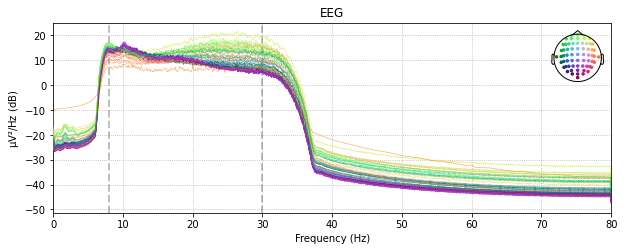

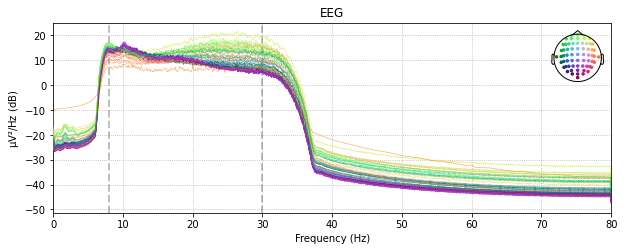

In [7]:
eeg.raw.plot_psd()

In [586]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import MaxPool1d
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, seq_len, channels)
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=bidirectional, 
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Set initial hidden and cell states
        #*2 because it's bidirectional
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device).float()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) 
        out = self.softmax(out)

        return out

In [587]:
import torch.cuda as cuda

model = CNN_Model_v1()

if cuda.is_available():
    print("cuda available")
    model = model.cuda()

In [588]:
model 

CNN_Model_v1(
  (conv1): Conv1d(1, 25, kernel_size=(11,), stride=(1,))
  (relu): LeakyReLU(negative_slope=0.01)
  (conv2): Conv1d(25, 25, kernel_size=(1,), stride=(1,))
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(25, 50, kernel_size=(11,), stride=(1,))
  (maxpool2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(50, 100, kernel_size=(11,), stride=(1,))
  (batchnorm2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(100, 200, kernel_size=(11,), stride=(1,))
  (batchnorm3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1):

In [589]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model CNN_Model_v1 has 291,462 trainable parameters


In [590]:
# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [591]:

X2 = X[:, 0:1, :]
y = y.reshape(300,1)
print(X2.shape)
print(y.shape)

(300, 1, 801)
(300, 1)


In [592]:
X_torch = torch.from_numpy(X2).float()
y_torch = torch.from_numpy(y)

In [593]:
# XX_torch = torch.unsqueeze(X_torch, 1)

In [594]:
print(X_torch.shape)
print(X_torch.type)
print(X_torch.dtype)

torch.Size([300, 1, 801])
<built-in method type of Tensor object at 0x0000016EA9ECF400>
torch.float32


In [595]:
# XX_torch.shape

In [596]:
y_torch.shape

torch.Size([300, 1])

In [597]:
from torch.utils.data import TensorDataset
ds = TensorDataset(X_torch, y_torch)

#Train test split
train_size = int(X_torch.size()[0] * 0.7)
valid_size = int(X_torch.size()[0] * 0.2)
test_size = int(X_torch.size()[0] * 0.1)

In [580]:
train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])

In [581]:
for i in train_set:
    print(i[0].shape)
    break

print(len(train_set))

torch.Size([1, 801])
210


In [582]:
BATCH_SIZE = 30
#Train set loader
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [583]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

7
2
1


In [584]:
for i, (signal, label) in enumerate(train_loader):
    print(signal.shape)
    print(label.shape)

torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])
torch.Size([30, 1, 801])
torch.Size([30, 1])


In [585]:
import torch.cuda as cuda
num_epochs = 300

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    print("EPOCH:", epoch)
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()
    
    for i, (items, classes) in enumerate(train_loader):
#         print("ITERATION:", i)
        items = Variable(items)
        classes = Variable(classes)
    
        optimizer.zero_grad()
#         print(items.dtype)
        classes = classes.long()
        outputs = outputs.long()
#         print(classes.dtype)
        outputs = model(items)
        loss = criterion(outputs, classes)
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    
    train_accuracy.append((100 * correct.float() / len(train_loader.dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()
    
    for i, (items, classes) in enumerate(valid_loader):
        classes = classes.long()
        outputs = outputs.long()
        items = Variable(items)
        classes = Variable(classes)
        
#         if cuda.is_available():
#             items = items.cuda(3)
#             classes = classes.cuda(3)
        
        outputs = model(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(valid_loader.dataset) * 100.0)
    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
               %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

EPOCH: 0
input X 1: torch.Size([30, 1, 801])
input X 2: torch.Size([30, 25, 791])
input X 3: torch.Size([30, 25, 791])
input X 4: torch.Size([30, 25, 791])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6000x761 and 801x1)

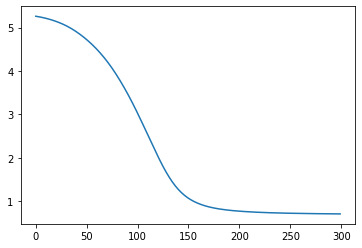

In [465]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(train_loss)


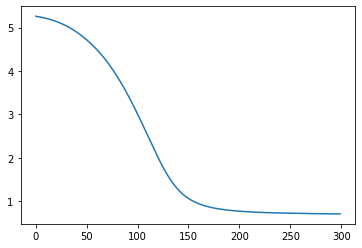

In [466]:
plt.plot(valid_loss)


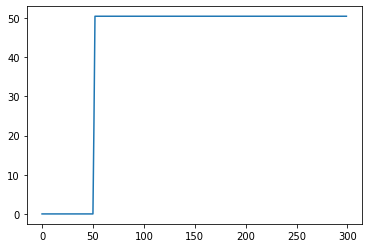

In [467]:
plt.plot(train_accuracy)
